In [ ]:
#@title Downloading dataset from GDrive
import gdown
import os

base_path = "Downloads/dataset"
os.makedirs(base_path, exist_ok=True)

link1 = "https://drive.google.com/uc?export=download&id=1TJy-nAS9L2xG3sSn0ZPK5MLaIib0yLHX"
link2 = "https://drive.google.com/uc?export=download&id=1f0VFieioGDig237kdHb-vDsSQ8IR7yCh"
link3 = "https://drive.google.com/uc?export=download&id=1nP3ACPxOClf0hGpw2iFHRZHg4aTLeKif"

path1 = os.path.join(base_path, "subtaskA_train_multilingual.jsonl") # Dev set
path2 = os.path.join(base_path, "subtaskA_dev_multilingual.jsonl") # Train set
path3 = os.path.join(base_path, "subtaskA_test_multilingual.jsonl")  # Test set(DO NOT TOUCH)

gdown.download(link1, path1, quiet=False)
gdown.download(link2, path2, quiet=False)
gdown.download(link3, path3, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1TJy-nAS9L2xG3sSn0ZPK5MLaIib0yLHX
From (redirected): https://drive.google.com/uc?export=download&id=1TJy-nAS9L2xG3sSn0ZPK5MLaIib0yLHX&confirm=t&uuid=bcf0884b-6e0c-47b0-aae3-a0a83966d899
To: /content/Downloads/dataset/subtaskA_train_multilingual.jsonl
100%|██████████| 587M/587M [00:05<00:00, 99.1MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1f0VFieioGDig237kdHb-vDsSQ8IR7yCh
To: /content/Downloads/dataset/subtaskA_dev_multilingual.jsonl
100%|██████████| 21.2M/21.2M [00:00<00:00, 94.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1nP3ACPxOClf0hGpw2iFHRZHg4aTLeKif
From (redirected): https://drive.google.com/uc?export=download&id=1nP3ACPxOClf0hGpw2iFHRZHg4aTLeKif&confirm=t&uuid=c9b2a9b6-f5cc-46e8-80a1-42fc28ac3d1b
To: /content/Downloads/dataset/subtaskA_test_multilingual.jsonl
100%|██████████| 117M/117M [00:00<00:00, 140MB/s]


'Downloads/dataset/subtaskA_test_multilingual.jsonl'

In [ ]:
#@title Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Installing dependencies
!pip install datasets evaluate accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.w

In [ ]:
#@title Importing libraries
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score,ConfusionMatrixDisplay

In [ ]:
#@title Utility functions

def preprocess_function(examples, **fn_kwargs):
    return fn_kwargs['tokenizer'](examples["text"], truncation=True)


def get_data(train_path, test_path, random_seed):

    train_df = pd.read_json(train_path, lines=True)
    # test_df = pd.read_json(test_path, lines=True)

    train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

    return train_df, val_df

def compute_metrics(eval_pred):

    f1_metric = evaluate.load("f1")

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    results = {}
    results.update(f1_metric.compute(predictions=predictions, references = labels, average="micro"))

    return results


def fine_tune(train_df, valid_df, checkpoints_path, id2label, label2id, model):

    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)

    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForSequenceClassification.from_pretrained(
       model, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )

    tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
    tokenized_valid_dataset = valid_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})


    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


    training_args = TrainingArguments(
        output_dir=checkpoints_path,
        learning_rate=1e-6,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # saving best model
    best_model_path = checkpoints_path+'/best/'

    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)


    trainer.save_model(best_model_path)


def test(test_df, model_path, id2label, label2id):

    # load tokenizer from saved model
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    model = AutoModelForSequenceClassification.from_pretrained(
       model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )

    test_dataset = Dataset.from_pandas(test_df)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    predictions = trainer.predict(tokenized_test_dataset)
    prob_pred = softmax(predictions.predictions, axis=-1)
    preds = np.argmax(predictions.predictions, axis=-1)
    metric = evaluate.load("bstrai/classification_report")
    results = metric.compute(predictions=preds, references=predictions.label_ids)

    return results, preds


###**eachlang and eachdomain(English) evaluation**

In [ ]:
#Analysying train_data
train_df = pd.read_json(path1, lines=True)
print("_____SOURCE_____")
print(train_df["source"].value_counts())
print("_____MODEL_____")
train_df["model"].value_counts()


_____SOURCE_____
source
wikihow       30999
reddit        30999
arxiv         30997
wikipedia     29029
peerread      14565
bulgarian     12000
chinese       11934
indonesian     5995
urdu           5899
Name: count, dtype: int64
_____MODEL_____


model
human      83846
chatGPT    26208
davinci    20307
bloomz     14332
dolly      14046
cohere     13678
Name: count, dtype: int64

In [ ]:
source_dict={}
for source in train_df.source.unique():
  source_dict[source] = train_df[train_df.source == source]
print(source_dict.keys())

model_dict = {}
for source,df in source_dict.items():
  model_dict[f'{source}_0'] = df[df.model == "human"]
  model_dict[f'{source}_1'] = df[(df.model.isin(["chatGPT","davinci","bloomz","dolly","cohere"]))]

for k ,v in model_dict.items():
  print(f'{k} : {len(v)}')

dict_keys(['wikihow', 'wikipedia', 'reddit', 'arxiv', 'bulgarian', 'urdu', 'indonesian', 'chinese', 'peerread'])
wikihow_0 : 15999
wikihow_1 : 15000
wikipedia_0 : 14997
wikipedia_1 : 14032
reddit_0 : 16000
reddit_1 : 14999
arxiv_0 : 15998
arxiv_1 : 14999
bulgarian_0 : 6000
bulgarian_1 : 6000
urdu_0 : 3000
urdu_1 : 2899
indonesian_0 : 2995
indonesian_1 : 3000
chinese_0 : 6000
chinese_1 : 5934
peerread_0 : 2857
peerread_1 : 11708


In [ ]:
#Creating train_data and test_data
first = model_dict["wikihow_0"]
train_df_80 = first[:int(0.8 * len(first))]
test_df_20 = first[int(0.8 * len(first)):]
for k , v in model_dict.items():
  if k == "wikihow_0":
    continue
  slice_train= v[:int(0.8*len(v))]
  slice_test= v[int(0.8 * len(v)):]
  train_df_80 = pd.concat([train_df_80,slice_train])
  test_df_20 = pd.concat([test_df_20,slice_test])
print(train_df_80.source.value_counts())
print(len(train_df_80))
print(test_df_20.source.value_counts())
print(len(test_df_20))
print(len(train_df_80)+len(test_df_20))


#train_data= train_df_80
#test_data = test_df_20

source
wikihow       24799
reddit        24799
arxiv         24797
wikipedia     23222
peerread      11651
bulgarian      9600
chinese        9547
indonesian     4796
urdu           4719
Name: count, dtype: int64
137930
source
wikihow       6200
reddit        6200
arxiv         6200
wikipedia     5807
peerread      2914
bulgarian     2400
chinese       2387
indonesian    1199
urdu          1180
Name: count, dtype: int64
34487
172417


In [ ]:
random_seed =0
train_path =  path1
dev_path =  path2
test_path = path3
model =  "xlm-roberta-base"
subtask =  'A'
prediction_path = os.path.join(base_path, "subtaskA_predictions.jsonl")

id2label = {0: "human", 1: "machine"}
label2id = {"human": 0, "machine": 1}

set_seed(random_seed)

train_df = train_df_80
dev_df = pd.read_json(dev_path, lines=True)
# test_df = pd.read_json(test_path, lines=True)

# test_df = train_df[int(0.8*len(train_df)):]
# train_df= train_df[:int(0.8*len(train_df))]
# train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

print(len(train_df))
print(len(dev_df))


137930
4000


In [ ]:
#@title Fine tuning
fine_tune(train_df, dev_df, f"{model}/subtask{subtask}/{random_seed}", id2label, label2id, model)
!zip -r bestmodel.zip "/content/xlm-roberta-base/subtaskA/0/best"
!cp bestmodel.zip /content/drive/MyDrive/

137930
4000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/137930 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.166400,2.509375,0.602250
2,0.135300,2.652605,0.604250
3,0.107100,3.083060,0.587000
4,0.099800,3.156124,0.594750
5,0.083000,3.389750,0.586500
6,0.085200,3.587191,0.586250
7,0.091000,3.556886,0.584500


Epoch,Training Loss,Validation Loss,F1
1,0.166400,2.509375,0.602250
2,0.135300,2.652605,0.604250
3,0.107100,3.083060,0.587000
4,0.099800,3.156124,0.594750
5,0.083000,3.389750,0.586500
6,0.085200,3.587191,0.586250
7,0.091000,3.556886,0.584500
8,0.060600,3.804360,0.580000
9,0.054600,3.838809,0.584000
10,0.056400,3.777490,0.589000


  adding: content/xlm-roberta-base/subtaskA/0/best/ (stored 0%)
  adding: content/xlm-roberta-base/subtaskA/0/best/tokenizer_config.json (deflated 77%)
  adding: content/xlm-roberta-base/subtaskA/0/best/config.json (deflated 51%)
  adding: content/xlm-roberta-base/subtaskA/0/best/tokenizer.json (deflated 76%)
  adding: content/xlm-roberta-base/subtaskA/0/best/sentencepiece.bpe.model (deflated 49%)
  adding: content/xlm-roberta-base/subtaskA/0/best/training_args.bin (deflated 51%)
  adding: content/xlm-roberta-base/subtaskA/0/best/special_tokens_map.json (deflated 52%)
  adding: content/xlm-roberta-base/subtaskA/0/best/model.safetensors (deflated 22%)


# **TESTING**

In [ ]:
!cp "/content/drive/MyDrive/Nomerge234_1e-6_10_16.zip" "Nomerge234_1e-6_10_16.zip"
!unzip "Nomerge234_1e-6_10_16.zip"

Archive:  Nomerge234_1e-6_10_16.zip
   creating: content/xlm-roberta-base/subtaskA/0/best/
  inflating: content/xlm-roberta-base/subtaskA/0/best/tokenizer_config.json  
  inflating: content/xlm-roberta-base/subtaskA/0/best/config.json  
  inflating: content/xlm-roberta-base/subtaskA/0/best/tokenizer.json  
  inflating: content/xlm-roberta-base/subtaskA/0/best/sentencepiece.bpe.model  
  inflating: content/xlm-roberta-base/subtaskA/0/best/training_args.bin  
  inflating: content/xlm-roberta-base/subtaskA/0/best/special_tokens_map.json  
  inflating: content/xlm-roberta-base/subtaskA/0/best/model.safetensors  


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Accuracy: 0.60225
Precision: 0.5631367706082124
Recall: 0.912
F1 Score: 0.6963160908570339


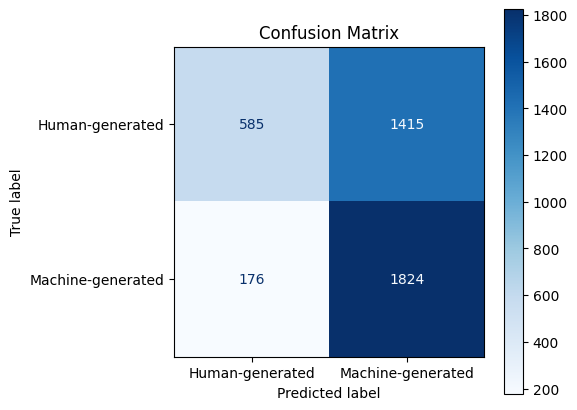

In [ ]:
#@title Testing on actual dev_set

test_df = dev_df
results, predictions = test(test_df, f"{model}/subtask{subtask}/{random_seed}/best/", id2label, label2id)

logging.info(results)
predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})



accuracy = accuracy_score(test_df['label'], predictions_df['label'])
precision = precision_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
recall = recall_score(test_df['label'], predictions_df['label'],pos_label=1, average='binary')
score = f1_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(f"F1 Score: {score}")

cm = confusion_matrix(test_df['label'], predictions_df['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-generated', 'Machine-generated'])

plt.figure(figsize=(5, 5))
disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

Map:   0%|          | 0/42378 [00:00<?, ? examples/s]

Accuracy: 0.807706829015055
Precision: 0.7320309131314472
Recall: 0.9968383017163505
F1 Score: 0.8441546023064124


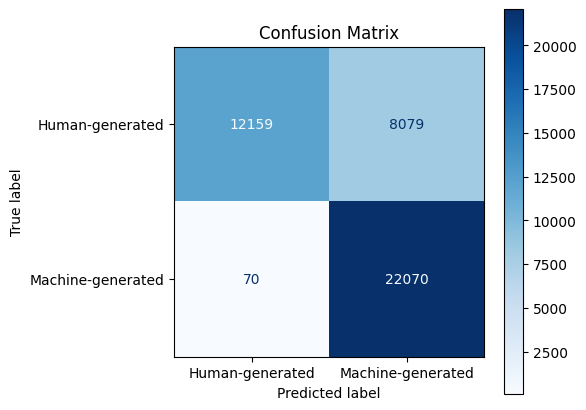

In [ ]:
#@title Testing on actual test_set

test_df = pd.read_json(test_path, lines=True)
results, predictions = test(test_df, f"{model}/subtask{subtask}/{random_seed}/best/", id2label, label2id)

logging.info(results)
predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})



accuracy = accuracy_score(test_df['label'], predictions_df['label'])
precision = precision_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
recall = recall_score(test_df['label'], predictions_df['label'],pos_label=1, average='binary')
score = f1_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(f"F1 Score: {score}")

cm = confusion_matrix(test_df['label'], predictions_df['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-generated', 'Machine-generated'])

plt.figure(figsize=(5, 5))
disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# In this model No merge , so taken as general model . no need to do below analysis on this.

Map:   0%|          | 0/34487 [00:00<?, ? examples/s]

Accuracy: 0.8491025603850726
Precision: 0.7788624409378622
Recall: 0.9862835854594717
F1 Score: 0.8703860523038606


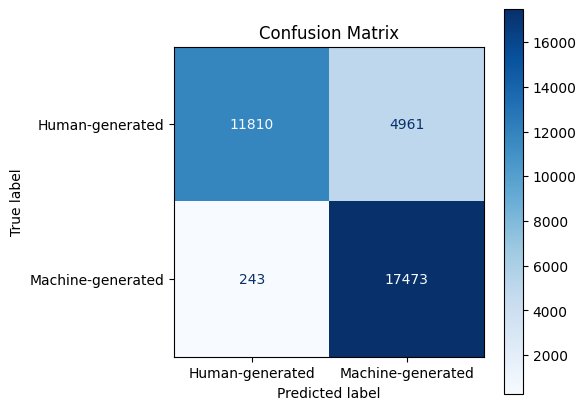

In [ ]:
#@title Testing on test_df_20

test_df = test_df_20
results, predictions = test(test_df, f"{model}/subtask{subtask}/{random_seed}/best/", id2label, label2id)

logging.info(results)
predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})

accuracy = accuracy_score(test_df['label'], predictions_df['label'])
precision = precision_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
recall = recall_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
score = f1_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(f"F1 Score: {score}")

cm = confusion_matrix(test_df['label'], predictions_df['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-generated', 'Machine-generated'])
plt.figure(figsize=(5, 5))
disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

Model Performance on English
----------------------------




Map:   0%|          | 0/27321 [00:00<?, ? examples/s]

Accuracy: 0.8457230701658065
Precision: 0.7774240393208222
Recall: 0.9837444342356351
F1 Score: 0.868499048451003


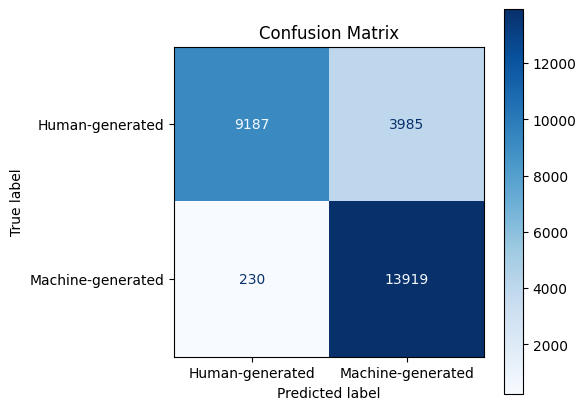

Model Performance on bulgarian
----------------------------




Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Accuracy: 0.8783333333333333
Precision: 0.808843537414966
Recall: 0.9908333333333333
F1 Score: 0.8906367041198502


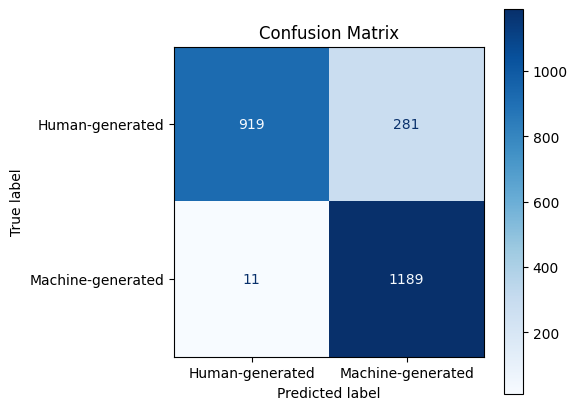

Model Performance on chinese
----------------------------




Map:   0%|          | 0/2387 [00:00<?, ? examples/s]

Accuracy: 0.8734813573523251
Precision: 0.797979797979798
Recall: 0.9983150800336984
F1 Score: 0.8869760479041916


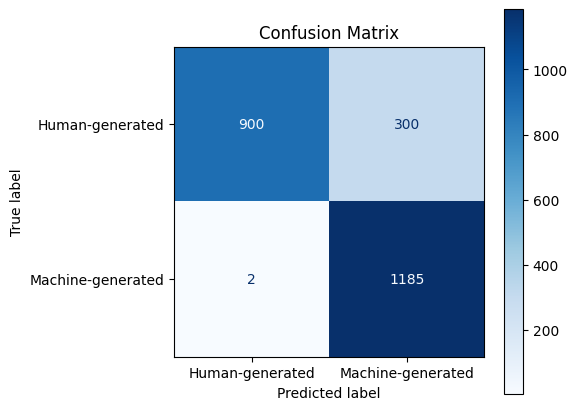

Model Performance on indonesian
----------------------------




Map:   0%|          | 0/1199 [00:00<?, ? examples/s]

Accuracy: 0.7731442869057548
Precision: 0.6880733944954128
Recall: 1.0
F1 Score: 0.8152173913043478


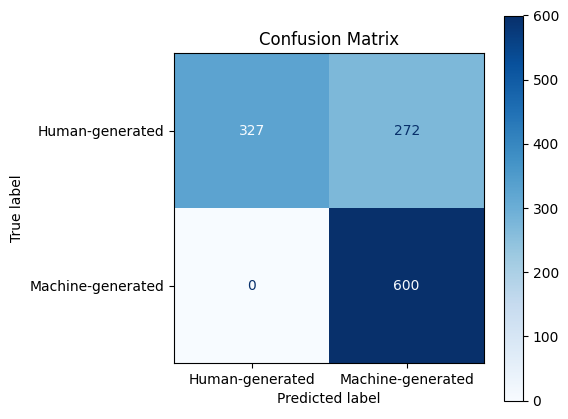

Model Performance on urdu
----------------------------




Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Accuracy: 0.8957627118644068
Precision: 0.8250355618776671
Recall: 1.0
F1 Score: 0.9041309431021044


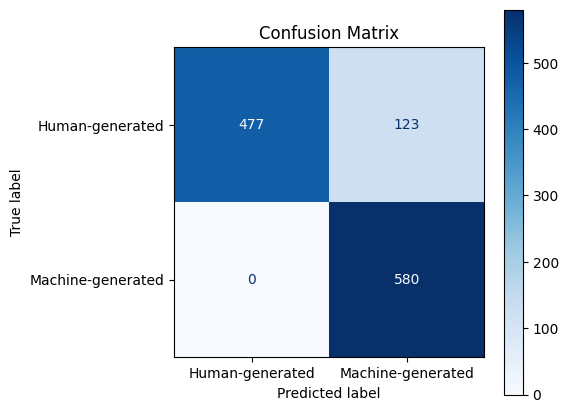

In [ ]:
#@title Testing for 5 languages separately
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score

lang_list = ["English","bulgarian","chinese","indonesian","urdu"]
for lang in lang_list:
  if lang == "English":
    print("Model Performance on English")
    test_df = test_df_20[(test_df_20.source.isin(["reddit","wikihow","arxiv","wikipedia","peerread"]))]
  else:
    print(f"Model Performance on {lang}")
    test_df = test_df_20[test_df_20.source == lang]

  print("----------------------------\n\n")
  results, predictions = test(test_df, f"{model}/subtask{subtask}/{random_seed}/best/", id2label, label2id)

  logging.info(results)
  predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})

  accuracy = accuracy_score(test_df['label'], predictions_df['label'])
  precision = precision_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
  recall = recall_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
  score = f1_score(test_df['label'], predictions_df['label'],pos_label=1, average='binary')

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print(f"F1 Score: {score}")

  cm = confusion_matrix(test_df['label'], predictions_df['label'])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-generated', 'Machine-generated'])
  plt.figure(figsize=(5, 5))
  disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
  plt.title('Confusion Matrix')
  plt.show()

Model Performance on reddit
-----------------------------/n


Map:   0%|          | 0/6200 [00:00<?, ? examples/s]

Accuracy: 0.8759677419354839
Precision: 0.7965966498271736
Recall: 0.9986666666666667
F1 Score: 0.8862594290785387


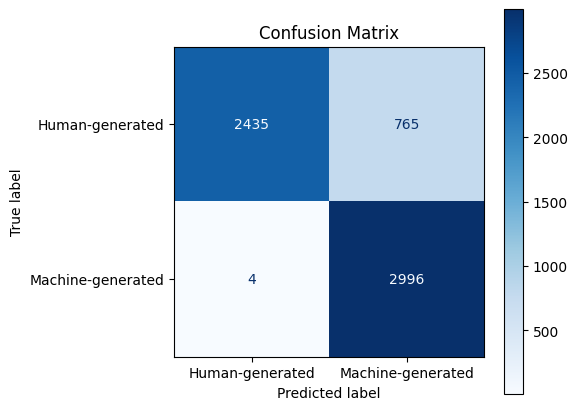

Model Performance on wikihow
-----------------------------/n


Map:   0%|          | 0/6200 [00:00<?, ? examples/s]

Accuracy: 0.9609677419354838
Precision: 0.9560185185185185
Recall: 0.9636666666666667
F1 Score: 0.9598273572377157


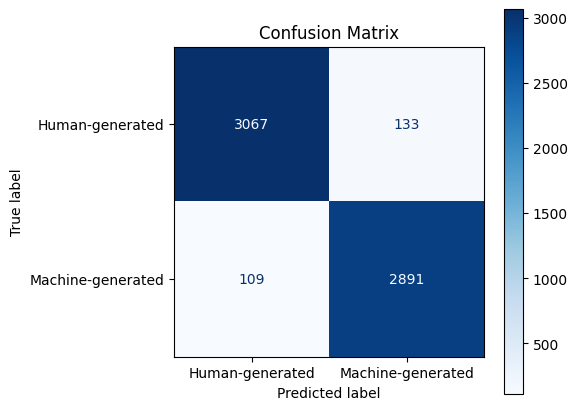

Model Performance on arxiv
-----------------------------/n


Map:   0%|          | 0/6200 [00:00<?, ? examples/s]

Accuracy: 0.724516129032258
Precision: 0.6387457044673539
Recall: 0.9913333333333333
F1 Score: 0.7769070010449319


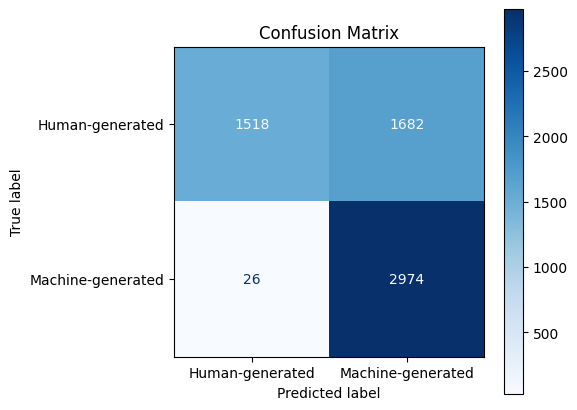

Model Performance on wikipedia
-----------------------------/n


Map:   0%|          | 0/5807 [00:00<?, ? examples/s]

Accuracy: 0.795247115550198
Precision: 0.7033685268979387
Recall: 0.9967937299608123
F1 Score: 0.8247605011053796


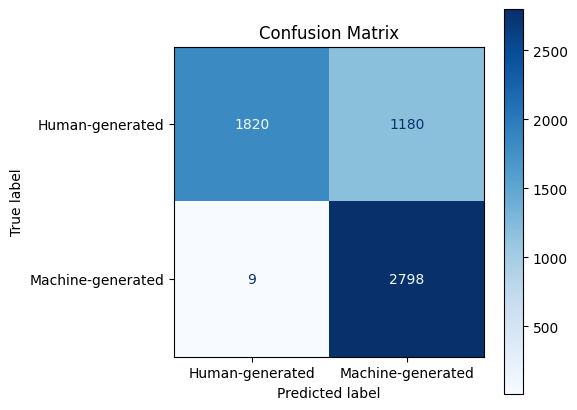

Model Performance on peerread
-----------------------------/n


Map:   0%|          | 0/2914 [00:00<?, ? examples/s]

Accuracy: 0.894646533973919
Precision: 0.9094567404426559
Recall: 0.9649871904355252
F1 Score: 0.9363994199295629


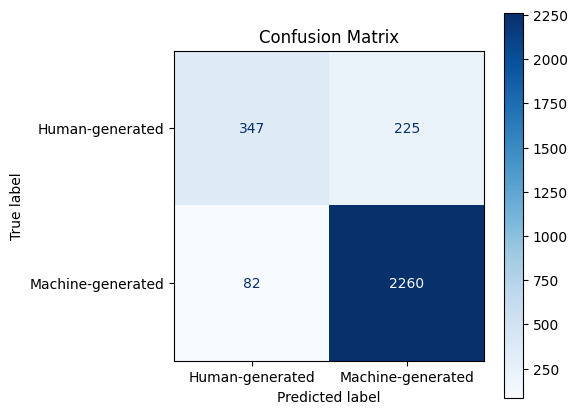

In [ ]:
#@title Testing for Domain specific for English
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score

domain_list = ["reddit","wikihow","arxiv","wikipedia","peerread"]
for domain in domain_list:
  print(f"Model Performance on {domain}")
  print("-----------------------------\n")
  test_df = test_df_20[test_df_20.source == domain]
  results, predictions = test(test_df, f"{model}/subtask{subtask}/{random_seed}/best/", id2label, label2id)

  logging.info(results)
  predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})

  accuracy = accuracy_score(test_df['label'], predictions_df['label'])
  precision = precision_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
  recall = recall_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
  score = f1_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print(f"F1 Score: {score}")

  cm = confusion_matrix(test_df['label'], predictions_df['label'])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-generated', 'Machine-generated'])
  plt.figure(figsize=(5, 5))
  disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
  plt.title('Confusion Matrix')
  plt.show()


Model Performance on data generated by chatGPT 
---------------------------------------------



Map:   0%|          | 0/3181 [00:00<?, ? examples/s]

Sources with mismatched labels:
source
bulgarian    5
Name: count, dtype: int64
Accuracy: 0.9984281672430053
Precision: 1.0
Recall: 0.9984281672430053
F1 Score: 0.9992134654711342


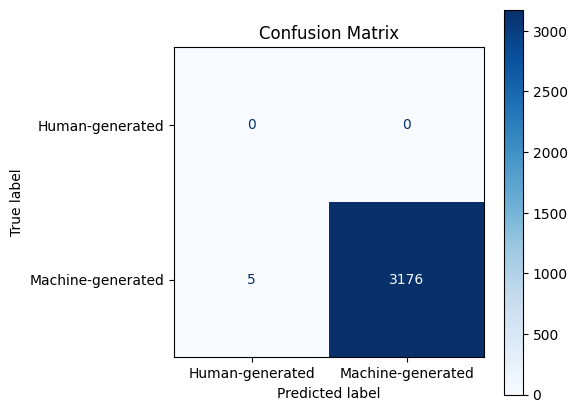

Model Performance on data generated by davinci 
---------------------------------------------



Map:   0%|          | 0/2693 [00:00<?, ? examples/s]

Sources with mismatched labels:
source
arxiv        9
bulgarian    6
chinese      2
wikipedia    1
Name: count, dtype: int64
Accuracy: 0.993316004455997
Precision: 1.0
Recall: 0.993316004455997
F1 Score: 0.9966467958271237


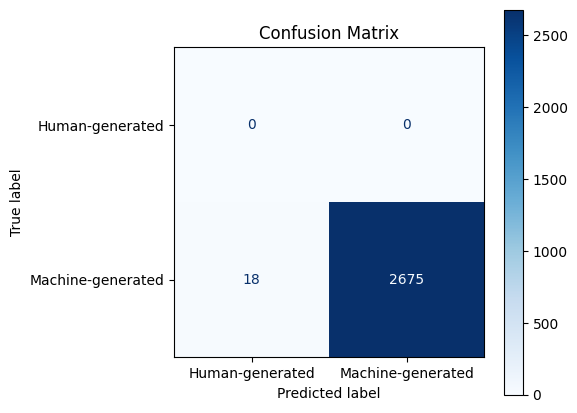

Model Performance on data generated by bloomz 
---------------------------------------------



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Sources with mismatched labels:
Series([], Name: count, dtype: int64)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[1000]]
Model Performance on data generated by dolly 
---------------------------------------------



Map:   0%|          | 0/6342 [00:00<?, ? examples/s]

Sources with mismatched labels:
source
wikihow      109
peerread      82
arxiv         16
wikipedia      7
Name: count, dtype: int64
Accuracy: 0.9662567013560391
Precision: 1.0
Recall: 0.9662567013560391
F1 Score: 0.9828388131515639


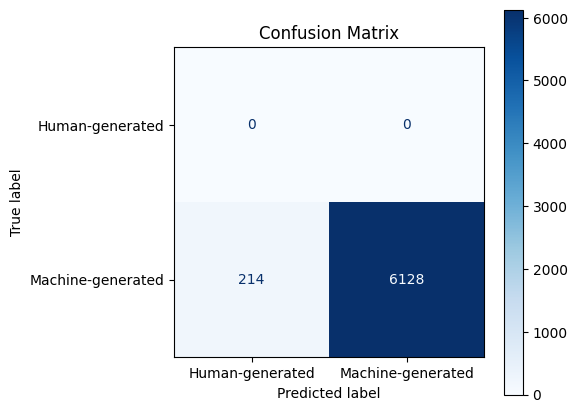

Model Performance on data generated by cohere 
---------------------------------------------



Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Sources with mismatched labels:
source
reddit       4
wikipedia    1
arxiv        1
Name: count, dtype: int64
Accuracy: 0.9986666666666667
Precision: 1.0
Recall: 0.9986666666666667
F1 Score: 0.9993328885923949


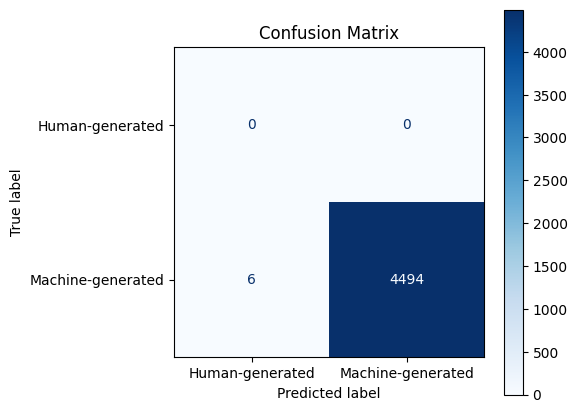

In [ ]:
#@title LLM-specific  performance
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score,ConfusionMatrixDisplay

llm_list = ["chatGPT","davinci","bloomz","dolly","cohere"]
for llm in llm_list:
  print(f"Model Performance on data generated by {llm} ")
  print("---------------------------------------------\n")
  test_df = test_df_20[test_df_20.model == llm]
  results, predictions = test(test_df, f"{model}/subtask{subtask}/{random_seed}/best/", id2label, label2id)

  logging.info(results)
  predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})

  mask = test_df['label'] != predictions_df['label']
  mismatched_sources = test_df.loc[mask, 'source']
  print("Sources with mismatched labels:")
  print(mismatched_sources.value_counts())


  accuracy = accuracy_score(test_df['label'], predictions_df['label'])
  precision = precision_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
  recall = recall_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
  score = f1_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print(f"F1 Score: {score}")

  cm = confusion_matrix(test_df['label'], predictions_df['label'])
  if cm.shape[0] == 1:
      print("Confusion Matrix:\n", cm)
      continue

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-generated', 'Machine-generated'])
  plt.figure(figsize=(5, 5))
  disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
  plt.title('Confusion Matrix')
  plt.show()



In [ ]:
import pandas as pd

# Example DataFrames
data_pred = {'Value': [31, 95, 41, 36, 'Nil', 93, 13]}
pred_df = pd.DataFrame(data_pred)

data_test = {'SomeColumn': ['a', 'b', 'c', 'd', 'e', 'f', 'g']}
test_df = pd.DataFrame(data_test)
nil_indices = pred_df.index[pred_df['Value'] == 'Nil'].tolist()
# Remove 'Nil' values from pred_df and reset the index
pred_df = pred_df[pred_df['Value'] != 'Nil'].reset_index(drop=True)

# Find indices where 'Nil' values were removed
# nil_indices = pred_df.index[pred_df['Value'] == 'Nil'].tolist()

# Remove corresponding rows in test_df
test_df = test_df.drop(nil_indices).reset_index(drop=True)

# Display the cleaned DataFrames
print("Cleaned pred_df:")
print(pred_df)
print("\nCleaned test_df:")
print(test_df)


Cleaned pred_df:
  Value
0    31
1    95
2    41
3    36
4    93
5    13

Cleaned test_df:
  SomeColumn
0          a
1          b
2          c
3          d
4          f
5          g


In [ ]:
import pandas as pd

# Example DataFrames
data_pred = {'Value': [31, 95, 41, 36, 'Nil', 93, 13]}
pred_df = pd.DataFrame(data_pred)

data_test = {'SomeColumn': ['a', 'b', 'c', 'd', 'e', 'f', 'g']}
test_df = pd.DataFrame(data_test)


eng_indices = test_df_15.index[test_df_15.source.isin(["reddit","wikihow","arxiv","wikipedia","peerread"])].tolist()
eng_df = test_df_15.drop(nil_indices).reset_index(drop=True)

# Remove 'Nil' values from pred_df and reset the index
pred_df = pred_df[pred_df['Value'] != 'Nil'].reset_index(drop=True)

# Find indices where 'Nil' values were removed
# nil_indices = pred_df.index[pred_df['Value'] == 'Nil'].tolist()

# Remove corresponding rows in test_df
test_df = test_df.drop(nil_indices).reset_index(drop=True)

# Display the cleaned DataFrames
print("Cleaned pred_df:")
print(pred_df)
print("\nCleaned test_df:")
print(test_df)


Cleaned pred_df:
  Value
0    31
1    95
2    41
3    36
4    93
5    13

Cleaned test_df:
  SomeColumn
0          a
1          b
2          c
3          d
4          f
5          g
